In [ ]:
!pip install tfa-nightly

     |████████████████████████████████| 747kB 17.9MB/s 


In [ ]:
!pip install tensorflow-addons

In [ ]:
# Import Library
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,BatchNormalization
from tensorflow.keras.layers import Conv2D,MaxPooling2D
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import RMSprop,SGD,Adam,Adadelta
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

In [ ]:
# Variable Definition
num_classes=7
height,width=48,48
batch_size=128

In [ ]:
!mkdir fer2013
!mkdir fer2013/train
!mkdir fer2013/test
! unzip -q '/content/drive/MyDrive/Datasets/fer2013/train.zip' -d fer2013/train
! unzip -q '/content/drive/MyDrive/Datasets/fer2013/test-public.zip' -d fer2013/test

In [ ]:
# Dataset Directory
train_data_dir='fer2013/train'
validation_data_dir='fer2013/test'

In [ ]:
def smooth_labels(y, smooth_factor):
    '''Convert a matrix of one-hot row-vector labels into smoothed versions.
    https://www.dlology.com/blog/bag-of-tricks-for-image-classification-with-convolutional-neural-networks-in-keras/?fbclid=IwAR2RXBIUkuSdc21cQd3n8AG9CmGtC7MbVgEj3SFm-cfIDyHcexp7YjIhJKs

    # Arguments
        y: matrix of one-hot row-vector labels to be smoothed
        smooth_factor: label smoothing factor (between 0 and 1)

    # Returns
        A matrix of smoothed labels.
    '''
    assert len(y.shape) == 2
    if 0 <= smooth_factor <= 1:
        # label smoothing ref: https://www.robots.ox.ac.uk/~vgg/rg/papers/reinception.pdf
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
    else:
        raise Exception(
            'Invalid label smoothing factor: ' + str(smooth_factor))
    return y

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    brightness_range = [0.8,1.2],
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    shear_range=0.1,
    zoom_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def train_gen(train_datagen) :
  while True :
    x, y = next(train_datagen)
    y = smooth_labels(y, 0.1)
    yield x, y

In [ ]:
train_generator = train_datagen.flow_from_directory(
 train_data_dir,
 color_mode='grayscale',
 target_size=(height,width),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

validation_generator = validation_datagen.flow_from_directory(
 validation_data_dir,
 color_mode='grayscale',
 target_size=(height,width),
 batch_size=batch_size,
 class_mode='categorical',
 shuffle=True)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [ ]:
# Model Definition
model = Sequential()
#Block-1
model.add(Conv2D(32,(3,3),padding='same',
                 input_shape=(height,width,1), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32,(3,3),padding='same',
                 input_shape=(height,width,1), kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

#Block-2
model.add(Conv2D(64,(3,3),padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(64,(3,3),padding='same', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

#Block-3
# model.add(Conv2D(128,(3,3),padding='same', kernel_initializer='he_uniform'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Conv2D(128,(3,3),padding='same', kernel_initializer='he_uniform'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same', kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),padding='same', kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
# model.add(Dropout(0.2))

#Block-4
# model.add(Conv2D(256,(3,3),padding='same', kernel_initializer='he_uniform'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same', kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),padding='same', kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

#Block-5
model.add(Flatten())
# model.add(Dense(128, kernel_initializer='he_uniform'))
# model.add(Activation('relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

#Block-6
model.add(Dense(128, kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
#Block-7
model.add(Dense(num_classes, kernel_initializer='he_uniform'))
model.add(Activation('softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 48, 48, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0

In [ ]:
# Compile and Train
checkpoint = ModelCheckpoint('EmotionDetectionModelv5.h5',
                             monitor='val_accuracy',
                             mode='max',
                             save_best_only=True,
                             verbose=1)
earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=10,
                          verbose=1,
                          restore_best_weights=True
                          )
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
callbacks = [earlystop,checkpoint,reduce_lr]

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4)

In [ ]:
model.compile(loss='categorical_crossentropy',
 optimizer = optimizer,
 metrics=['accuracy'])

nb_train_samples = 28709
nb_validation_samples = 3589
epochs=100

history=model.fit(
 train_gen(train_generator),
 steps_per_epoch=nb_train_samples//batch_size,
 epochs=epochs,
 callbacks=callbacks,
 validation_data=validation_generator,
 validation_steps=nb_validation_samples//batch_size)

Epoch 1/100
224/224 [==============================] - ETA: 0s - loss: 2.0492 - accuracy: 0.2230
Epoch 00001: val_accuracy improved from -inf to 0.25279, saving model to EmotionDetectionModelv5.h5
224/224 [==============================] - 25s 113ms/step - loss: 2.0492 - accuracy: 0.2230 - val_loss: 1.9114 - val_accuracy: 0.2528
Epoch 2/100
224/224 [==============================] - ETA: 0s - loss: 1.7800 - accuracy: 0.3139
Epoch 00002: val_accuracy improved from 0.25279 to 0.35463, saving model to EmotionDetectionModelv5.h5
224/224 [==============================] - 25s 112ms/step - loss: 1.7800 - accuracy: 0.3139 - val_loss: 1.6683 - val_accuracy: 0.3546
Epoch 3/100
224/224 [==============================] - ETA: 0s - loss: 1.6372 - accuracy: 0.3989
Epoch 00003: val_accuracy improved from 0.35463 to 0.42690, saving model to EmotionDetectionModelv5.h5
224/224 [==============================] - 25s 112ms/step - loss: 1.6372 - accuracy: 0.3989 - val_loss: 1.4743 - val_accuracy: 0.4269
E

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


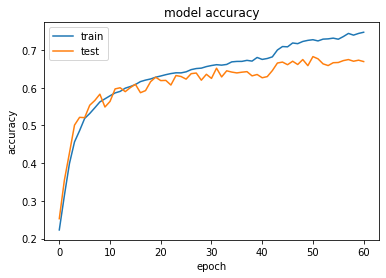

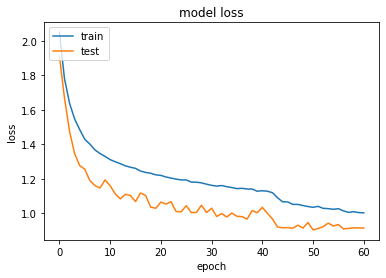

In [ ]:
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
!cp './EmotionDetectionModelv5.h5' '/content/drive/MyDrive/Colab Notebooks/DL/_Project'